<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/Numpyro_MC_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q numpyro==0.10.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 KB 12.0 MB/s eta 0:00:00


In [ ]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import HMC, NUTS,  BarkerMH,  MCMC, init_to_sample


In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
#import jaxopt

from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18

from jax.config import config
config.update("jax_enable_x64", True)

import scipy as sc
from scipy.optimize import minimize as sc_minimize
import scipy.stats as scs
import scipy.integrate as sc_integrate


In [ ]:
! pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install arviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import corner
import arviz as az

In [ ]:

numpyro.__version__

'0.10.0'

# Simple gaussian dist.

In [ ]:
# One possibility to use jit on function in the class is to use a off-class function 
# this is due to the self arg
# There are alternatives w/o any class
@jit
def _logpdf(x, loc, scale, weights):
  log_probs = jax.scipy.stats.norm.logpdf(x,loc=loc, scale=scale)
  return jax.scipy.special.logsumexp(jnp.log(weights) + log_probs, axis=0)

class MixtureModel_jax():
    def __init__(self, locs, scales, weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loc = jnp.array([locs]).T
        self.scale = jnp.array([scales]).T
        self.weights = jnp.array([weights]).T
        norm = jnp.sum(self.weights)
        self.weights = self.weights/norm

        self.num_distr = len(locs)

    def pdf(self, x):
        probs = jax.scipy.stats.norm.pdf(x,loc=self.loc, scale=self.scale)
        return jnp.dot(self.weights.T,probs).squeeze()
    
    def logpdf(self, x):
        return _logpdf(x, self.loc, self.scale, self.weights)[0]


In [ ]:
# \phi(x)
def phi(x):
    return x**2


In [ ]:
single_gaussian_model = MixtureModel_jax([0],[1],[1])

In [ ]:
Integ_true,_=sc_integrate.quad(lambda x: phi(x)*single_gaussian_model.pdf(x),-7,7)

In [ ]:
single_gaussian_model.logpdf(0.)

DeviceArray(-0.91893853, dtype=float64)

In [ ]:
print("Integ. true: ",Integ_true)

Integ. true:  0.9999999998695543


In [ ]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

# Use a HMC 
kernel = HMC(potential_fn=lambda x: -single_gaussian_model.logpdf(x))  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False) # progress_bar=True ralentit bcq... donc ok pour num_samples=1000.
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]     -0.00      1.00     -0.00     -1.65      1.64 219315.47      1.00

Number of divergences: 0


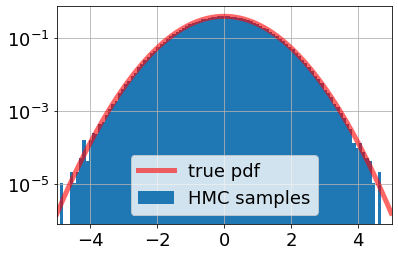

In [ ]:
fig = plt.figure()
x_axis = np.arange(-5, 5, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(np.array(samples_1.squeeze()), bins=100, density=True, label="HMC samples");
plt.plot(x_axis, single_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-5,5])
plt.yscale('log')
plt.grid()
plt.legend();


You can use the samples to compute $\int \phi(x) p(x) dx$

In [ ]:

phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")


Integ_HMC:9.977529e-01, err. relat: 2.247060e-03, sample size : 1000000


In [ ]:
# realtive effective sample size
az.ess(np.array(samples_1.squeeze()), relative=True)

0.21931631741854699

So the Relative ESS is of about 22% which is quite ok but this is for a simple case.

# Mixture of gaussian dist.

In [ ]:
mixture_gaussian_model = MixtureModel_jax([0,1.5],[0.5,0.1],[8,2])

In [ ]:
Integ_true,_=sc_integrate.quad(lambda x: phi(x)*mixture_gaussian_model.pdf(x),-7,7)

In [ ]:
print("Integ. true: ",Integ_true)

Integ. true:  0.652


In [ ]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel = HMC(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x),
            trajectory_length=1.0)  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.30      0.75      0.16     -0.63      1.64  28707.19      1.00

Number of divergences: 0


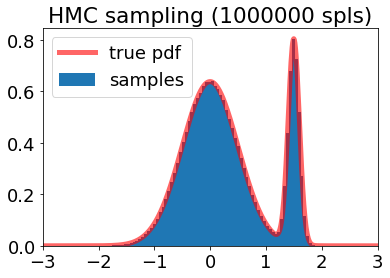

In [ ]:
fig = plt.figure()
x_axis = np.arange(-3, 3, 0.01)
#mixture_pdf = jax.vmap(mixture_gaussian_model.pdf)(x_axis)
plt.hist(np.array(samples_1.squeeze()), bins=100, density=True, label="samples");
plt.plot(x_axis, mixture_gaussian_model.pdf(x_axis),'r-', lw=5, alpha=0.6, label='true pdf')
plt.xlim([-3,3])
plt.title(f"HMC sampling ({len(samples_1.flatten())} spls)")
plt.legend();

In [ ]:
phi_spl1 = phi(samples_1)
Integ_HMC1 = np.mean(phi_spl1)
print(f"Integ_HMC:{Integ_HMC1:.6e}, err. relat: {np.abs(Integ_HMC1-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_HMC:6.555026e-01, err. relat: 5.372124e-03, sample size : 1000000


In [ ]:
az.ess(np.array(samples_1.squeeze()), relative=True)

0.03852060519618474

So we get a less good sampling efficiency (3.8%) on this case with secondary peak. Even if HMC is an improvement compared to M-H (reminder: eff. of 0.1%) we can find a better method. Moreover, one can play with the `trajectory_lengt` parameter of the HMC and see the result sensitivity.

In [ ]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel =  BarkerMH(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x),
                   target_accept_prob=0.4)  # negative log
num_samples = 1_000_000
n_chains    = 2
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_2 = mcmc.get_samples()

<ipython-input-83-bb7778eca129>:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains,



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.30      0.75      0.16     -0.63      1.64  93946.83      1.00



In [ ]:
phi_spl1 = phi(samples_2)
Integ_NUTS = np.mean(phi_spl1)
print(f"Integ_NUTS:{Integ_NUTS:.6e}, err. relat: {np.abs(Integ_NUTS-Integ_true)/Integ_true:.6e}, sample size : {len(samples_1.flatten())}")

Integ_NUTS:6.518708e-01, err. relat: 1.981045e-04, sample size : 1000000


In [ ]:
az.ess(np.array(samples_2.squeeze()), relative=True)

0.07508978475976032

In [ ]:
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

kernel =  NUTS(potential_fn=lambda x: -mixture_gaussian_model.logpdf(x))  # negative log
num_samples = 1_000_000
n_chains    = 1
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples, num_chains=n_chains, 
            progress_bar=False)
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_3 = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.30      0.75      0.16     -0.63      1.64  16740.41      1.00

Number of divergences: 0


In [ ]:
az.ess(np.array(samples_3.squeeze()), relative=True)

0.021933060207131323

In low dimension BarkerMH may be better than HMC/NUTS. BarkerMH use a proposal distribution that uses the gradient of the potential. In particular the proposal distribution is skewed in the direction of the gradient at the current sample.

# Bayesian forward modeling of a simple 4-parameters use-case

## Dataset generation method1 

In [ ]:
 def mean_fn(x, params):
    """ a mean/determinist fnt with a split at t=0 """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))


In [ ]:
#dataset (method 1)
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

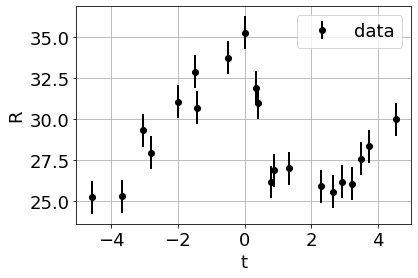

In [ ]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();


## The (Numpyro) fowrward model

In [ ]:
def model(t,Robs=None,
          R0_min=10.,v_min = 0.5,k_min = 1., tau_min=0.1,
          R0_max=50.,v_max = 3.5,k_max = 10., tau_max=5.0,
          sigma= 1.0):
    
    # priors on the parameters (stochastic but can be used as regular variables)
    # the variable naming is necessary in the dictionnary produced
    R0 = numpyro.sample("R0", dist.Uniform(R0_min,R0_max))
    v  = numpyro.sample("v", dist.Uniform(v_min,v_max))
    k  = numpyro.sample("k", dist.Uniform(k_min,k_max))
    tau= numpyro.sample("tau", dist.Uniform(tau_min,tau_max))

    params = {"R0":R0, "v":v, "k":k, "tau":tau}
    mu = mean_fn(t,params) # the mean
    
    with numpyro.plate("obs", t.shape[0]):  # each mesure is a random variable iid
        numpyro.sample('R', dist.Normal(mu, sigma), obs=Robs) # the likelihood


### Diagramatic representation

In [ ]:
! pip install -q graphviz

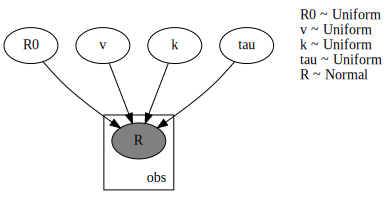

In [ ]:
numpyro.render_model(model, model_args=(jnp.array([0.]),jnp.array([1.])),
                    render_distributions=True)



## The forward model can be used also to generate dataset

In [ ]:
#dataset method 2

from numpyro.handlers import seed, trace, condition
# So, let's generate the data at the fiducial parameters
fiducial_model = condition(model, par_true)
# Run the conditionned model (if not conditionned the priors are executed)
trace_data = trace(seed(fiducial_model, jax.random.PRNGKey(42))).get_trace(tMes, sigma=sigma_obs)


In [ ]:
RMes_bis = trace_data['R']["value"]

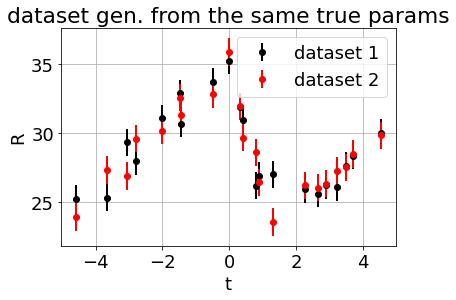

In [ ]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="dataset 1")
plt.errorbar(tMes,RMes_bis,yerr=sigma_obs, fmt='o', linewidth=2, capsize=0, c='r', 
             label="dataset 2")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.title("dataset gen. from the same true params")
plt.grid();


## Use sampler

In [ ]:
# Run NUTS.
kernel = NUTS(model, dense_mass=True, target_accept_prob=0.9,
              init_strategy=numpyro.infer.init_to_median())
num_samples = 5_000
n_chains = 4
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,
            chain_method='vectorized', # chain in paralell on the same device
            progress_bar=False)
mcmc.run(rng_key, t=tMes, Robs=RMes,sigma=sigma_obs, k_max = 20.)
mcmc.print_summary()
samples_nuts = mcmc.get_samples()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0     35.30      0.54     35.31     34.40     36.17   6548.26      1.00
         k     16.56      1.32     16.58     14.46     18.84   4771.67      1.00
       tau      0.95      0.11      0.95      0.77      1.14  13207.26      1.00
         v      2.36      0.21      2.36      2.01      2.71   5912.98      1.00

Number of divergences: 0


If you want to observe the progress bar with chain_method='vectorized' it will give only one string maybe but it is 4 that will be generated. This progress bar in some cases slows down the generation a lot. You can choose chain_method='sequential', while `parallel` requires like pmap a number of devices identical to the number of strings.


You can play on `num_warmup`, `num_samples`and `n_chains` to see how the sampling quality evolves...

We have to look at: `r_hat` which must be 1. The number of divergences which if not null indicates that the generation has been cut because of a problem (ex. frontier, squeezed proba...). Finally, `n_eff` which if divided by 4x5000 gives the generation efficiency. There is another (standard) way to calculate this efficiency via arviz.ess. This efficiency is related to the auto-correlation length of the Markov chain, or in other words to the independence of the samples.



In [ ]:
az.ess(samples_nuts, relative=True)  # relative efficiency 

<xarray.Dataset>
Dimensions:  ()
Data variables:
    R0       float64 0.3233
    k        float64 0.2213
    tau      float64 0.6673
    v        float64 0.2876

Note that the efficiency is >= 25% which is very good. A simple MCMC usually reaches 0.1% or less and we then have to generate a lot of samples, and then we proceed to a thinning which is very problematic from a statistical point of view because we have no guarantee to produce an iid batch.

In [ ]:
# Run NUTS.
kernel = HMC(model)
num_samples = 5_000
n_chains = 4
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,
            chain_method='vectorized', # chain in paralell on the same device
            progress_bar=False)
mcmc.run(rng_key, t=tMes, Robs=RMes,sigma=sigma_obs, k_max = 20.)
mcmc.print_summary()
samples_hmc = mcmc.get_samples()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0     35.32      0.54     35.31     34.43     36.20   7522.59      1.00
         k     16.55      1.31     16.54     14.33     18.66  14340.34      1.00
       tau      0.95      0.11      0.94      0.77      1.12    546.41      1.01
         v      2.36      0.21      2.36      2.02      2.71  31397.59      1.00

Number of divergences: 0


In [ ]:
az.ess(samples_hmc, relative=True)  # relative efficiency 

<xarray.Dataset>
Dimensions:  ()
Data variables:
    R0       float64 0.3797
    k        float64 0.7071
    tau      float64 0.02874
    v        float64 1.544

Notice the poor efficiency for the $\tau$ sampling.

## Posterior contours

In [ ]:
data = az.from_dict(
    posterior=samples_nuts  # dictionary od samplings
)
     


In [ ]:
# mean value of the parameter posterior
param_mean = np.mean(np.array(list(samples_nuts.values())),axis=1)
param_mean


array([35.30460682, 16.56110037,  0.95456448,  2.35695582])

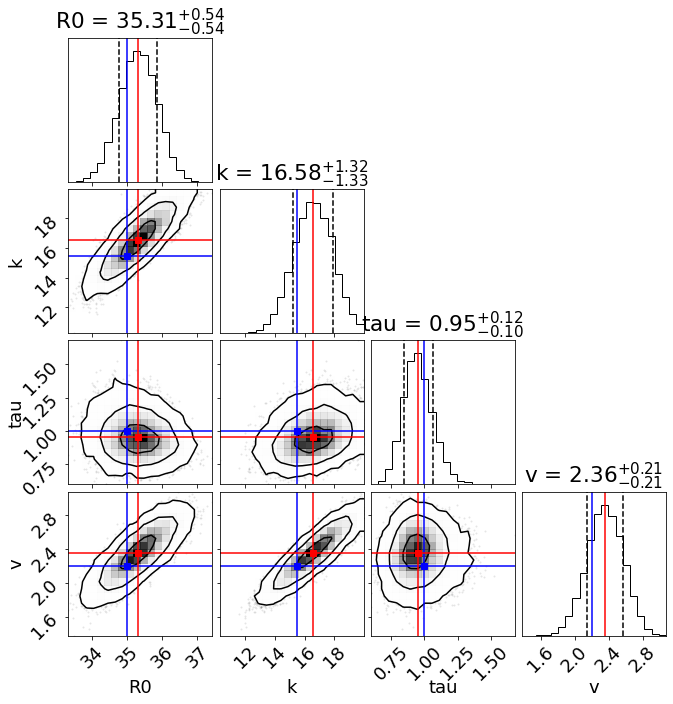

In [ ]:
figure = corner.corner(data, 
                       levels=(0.393, 0.865, 0.989),  #Plot 1sigma, 2sigma, 3sigma 2D contours
                        quantiles=[0.16, 0.84], #68% CL 1D plmlots = 1sigma
                       show_titles=True,
                       )
#true parameter positions
tmp = np.array([par_true["R0"],par_true["k"], par_true["tau"], par_true["v"]])
corner.overplot_lines(figure, tmp, color="blue")
corner.overplot_points(figure, tmp[None], marker="s", color="blue")
#mean MCMC parameter positions
corner.overplot_lines(figure, param_mean, color="red")
corner.overplot_points(figure, param_mean[None], marker="s", color="red")




## Prediction: mean, error bands...

In [ ]:
t_val = np.linspace(-5,5,100) # some new values of the t (time)

In [ ]:
Rtrue_val = mean_fn(t_val,par_true) # prediction with True parameter values (like method1 dataset)

In [ ]:
func = jax.vmap(lambda x: mean_fn(t_val,x))

In [ ]:
Rall_val= func(samples_nuts)  # use of MCMC chain samples

In [ ]:
Rmean_val = jnp.mean(Rall_val,axis=0) # mean expectation (predict)

In [ ]:
std_R_val = jnp.std(Rall_val,axis=0) # standard error

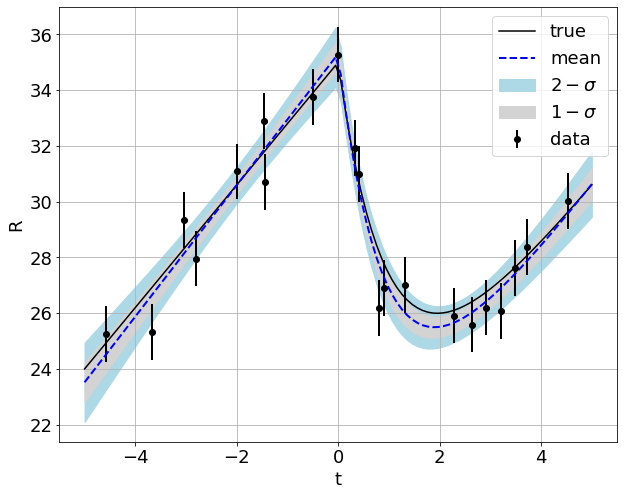

In [ ]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")

plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();


# Possible exos:
- Resume the dataset generation exercise without conditioning by fixed parameters but leave the generation by priors free:  `trace_data = trace(seed(model, jax.random.RNGKey(42))).get_trace(tMes, sigma=sigma_obs)` 
extract the parameters (R0,v,k,tau) generated and continue until the last comparison figure (truth/prediction).

- In the forward model, we have used Uniform priors, but we can wonder if this is a choice that does not condition the result too much. If you take a look at the documentation, I suggest that you change the distribution to LogNormal, HalfCauchy, InverseGamma... 

# Takeaway 

- You have learned how to code a Bayesian model with Numpyro that involves priors and likelihood.

- A new method is available (forward modeling) to generate datasets from this model.

- Markov chain generation via NUTS/HMC... is simple to code and you can add arviz to help diagnostics

- Note that besides Pyro has its JAX version (ie. Numpyro), PyMC3 is faster with JAX [(read this)](https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/GLM-hierarchical-jax.html)